In [1]:
import findspark
import happybase
import pandas as pd
import numpy as np

In [2]:
findspark.init()

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

spark = (
    SparkSession.builder
    .appName("StackExchange")
    .getOrCreate()
)

23/12/20 19:18:43 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
23/12/20 19:18:43 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/12/20 19:18:44 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
VM_address = 'localhost'
conn = happybase.Connection(VM_address)

# Wczytanie danych ze StackOverflow

In [5]:
table_name = 'stackoverflow'
table_stackoverflow = conn.table(table_name)

In [6]:
df_online_rows = []
df_online_tags_rows = []

for key, data in table_stackoverflow.scan():        
    owner_account_id = int(data.get(b'owner:account_id', b'0').decode('UTF-8'))
    if owner_account_id == 0:
        owner_account_id = None
        
    owner_reputation = int(data.get(b'owner:reputation', b'-1000000000').decode('UTF-8'))
    if owner_reputation == -1000000000:
        owner_reputation = None
    
    owner_user_id = int(data.get(b'owner:user_id', b'-1000000000').decode('UTF-8'))
    if owner_user_id == -1000000000:
        owner_user_id = None
        
    new_row = {
        'owner_account_id': owner_account_id,
        'owner_reputation': owner_reputation,
        'owner_user_id': owner_user_id,
        'owner_user_type': data[b'owner:user_type'].decode('UTF-8'),
        'post_answer_count': int(data[b'post_details:answer_count'].decode('UTF-8')),
        'post_creation_date': int(data[b'post_details:creation_date'].decode('UTF-8')),
        'post_is_answered': bool(data[b'post_details:is_answered'].decode('UTF-8')),
        'post_last_activity_date': int(data[b'post_details:last_activity_date'].decode('UTF-8')),
        'post_score': int(data[b'post_details:score'].decode('UTF-8')),
        'post_title': data[b'post_details:title'].decode('UTF-8'),
        'post_view_count': int(data[b'post_details:view_count'].decode('UTF-8')),
        'question_id': int(key.decode('UTF-8'))
    }
    df_online_rows.append(new_row)
    tags = [t.strip('"') for t in data[b'tags:tags'].decode('UTF-8').strip('[]').split(',')]
    for tag in tags:
        df_online_tags_rows.append({'question_id': new_row['question_id'],
                                   'tag': tag})
        
df_online = pd.DataFrame(df_online_rows)
df_online_tags = pd.DataFrame(df_online_tags_rows)

In [7]:
df_online

,owner_account_id,owner_reputation,owner_user_id,owner_user_type,post_answer_count,post_creation_date,post_is_answered,post_last_activity_date,post_score,post_title,post_view_count,question_id
0,22229702.0,11.0,16466102.0,registered,1,1640993065,True,1640994424,0,Get the nodeValues of all parent elements of e...,189,70546197
1,12575462.0,711.0,9582542.0,registered,2,1640993067,True,1641075240,5,Python Beautiful soup get correct column heade...,1432,70546198
2,23795851.0,21.0,17806699.0,registered,1,1640993182,True,1641199306,1,How can display a random icons into cards usin...,396,70546203
3,23508471.0,55.0,17557338.0,registered,1,1640993198,True,1640993804,0,C++ how can I create an array of objects when ...,282,70546204
4,16722064.0,21.0,12086705.0,registered,1,1640993212,True,1640993580,0,How to ask for infinite inputs until user repl...,24,70546206
...,...,...,...,...,...,...,...,...,...,...,...,...
85345,7473671.0,1372.0,6196488.0,registered,1,1702418256,True,1702419831,0,Pass Options into Common Autocomplete Component,21,77649231
85346,1589784.0,5319.0,1601580.0,registered,0,1702418294,True,1702418294,0,How to install swarms; AssertionError: Error: ...,14,77649233
85347,29875494.0,1.0,23090249.0,registered,1,1702418308,True,1702484496,0,WinError 10061 : NLTK - No connection could be...,20,77649234
85348,19821205.0,187.0,14517741.0,registered,1,1702418325,True,1702425432,0,Console application solutions can&#39;t be bui...,58,77649235


In [8]:
df_online_tags

,question_id,tag
0,70546197,javascript
1,70546197,html
2,70546197,nodes
3,70546198,python
4,70546198,python-3.x
...,...,...
261605,77649234,windows-firewall
261606,77649235,c#
261607,77649235,.net
261608,77649235,visual-studio


# Wczytanie danych z Data Science StackExchange

In [9]:
table_name = 'datascience_posts'
table_datascience_posts = conn.table(table_name)
table_name = 'datascience_users'
table_datascience_users = conn.table(table_name)

In [10]:
df_static_posts_rows = []
df_static_tags_rows = []

for key, data in table_datascience_posts.scan():
    last_edit_date = data.get(b'post:lastEditDate', b'').decode('UTF-8')
    if last_edit_date == '':
        last_edit_date = None
    
    closed_date = data.get(b'post:closedDate', b'').decode('UTF-8')
    if closed_date == '':
        closed_date = None
        
    owner_user_id = int(data.get(b'post:ownerUserId', b'0').decode('UTF-8'))
    if owner_user_id == 0:
        owner_user_id = None
        
    new_row = {
        'answer_count': int(data[b'post:answerCount'].decode('UTF-8')),
        'comment_count': int(data[b'post:commentCount'].decode('UTF-8')),
        'creation_date': data[b'post:creationDate'].decode('UTF-8'),
        'last_activity_date': data[b'post:lastActivityDate'].decode('UTF-8'),
        'last_edit_date': last_edit_date,
        'closed_date': closed_date,
        'owner_user_id': owner_user_id,
        'score': int(data[b'post:score'].decode('UTF-8')),
        'view_count': int(data[b'post:viewCount'].decode('UTF-8')),
        'question_id': key.decode('UTF-8'),
    }
    df_static_posts_rows.append(new_row)
    tags = data[b'tags:tags'].decode('UTF-8').strip('<>').split('><')
    for tag in tags:
        df_static_tags_rows.append({'question_id': new_row['question_id'],
                                   'tag': tag})
        
df_static_posts = pd.DataFrame(df_static_posts_rows)
df_static_tags = pd.DataFrame(df_static_tags_rows)

In [11]:
df_static_posts

,answer_count,comment_count,creation_date,last_activity_date,last_edit_date,closed_date,owner_user_id,score,view_count,question_id
0,1,2,2016-01-27T19:58:00.083,2017-12-27T20:43:21.200,2016-01-27T21:00:53.283,None,8820.0,15,7402,10000
1,2,0,2021-08-12T18:39:11.853,2021-08-18T12:36:43.523,None,None,121019.0,1,215,100001
2,0,3,2021-08-12T19:03:02.970,2021-08-12T19:03:02.970,None,None,122641.0,0,114,100003
3,0,2,2021-08-12T19:11:52.057,2021-08-12T19:11:52.057,None,None,120849.0,0,58,100005
4,1,0,2021-08-12T22:02:42.877,2021-08-14T01:20:57.533,None,None,112224.0,0,117,100010
...,...,...,...,...,...,...,...,...,...,...
36599,2,0,2021-08-12T12:02:47.993,2022-07-23T21:05:25.617,None,None,122916.0,0,1347,99987
36600,1,3,2016-01-27T19:56:50.257,2016-01-28T21:54:28.953,None,None,15797.0,4,2755,9999
36601,0,0,2021-08-12T15:52:27.427,2021-08-12T15:52:27.427,None,None,21254.0,1,280,99995
36602,1,1,2021-08-12T16:00:51.823,2021-08-13T09:09:35.563,2021-08-12T19:53:56.573,None,51670.0,0,22,99996


In [12]:
df_static_tags

,question_id,tag
0,10000,bayesian-networks
1,10000,pgm
2,100001,machine-learning
3,100001,nlp
4,100001,transformer
...,...,...
112398,99996,semantic-similarity
112399,99998,machine-learning
112400,99998,python
112401,99998,clustering


In [13]:
df_static_users_rows = []

for key, data in table_datascience_users.scan():
    location = data.get(b'user:location', b'').decode('UTF-8')
    if location == '':
        location = None
        
    new_row = {
        'location': owner_reputation,
        'creation_date': data[b'user:creationDate'].decode('UTF-8'),
        'down_votes': int(data[b'user:downVotes'].decode('UTF-8')),
        'up_votes': int(data[b'user:upVotes'].decode('UTF-8')),
        'reputation': int(data[b'user:reputation'].decode('UTF-8')),
        'views': int(data[b'user:views'].decode('UTF-8')),
        'user_id': int(key.decode('UTF-8')),
    }
    df_static_users_rows.append(new_row)
        
df_static_users = pd.DataFrame(df_static_users_rows)

In [14]:
df_static_users

,location,creation_date,down_votes,up_votes,reputation,views,user_id
0,1030,2014-05-13T21:29:22.820,2148,841,1,495,-1
1,1030,2014-05-13T22:58:54.810,0,0,101,723,1
2,1030,2014-05-13T23:18:31.953,0,1,101,5,10
3,1030,2014-05-14T06:06:21.970,0,38,101,2,100
4,1030,2014-06-19T05:17:11.773,0,0,1,3,1000
...,...,...,...,...,...,...,...
134331,1030,2020-06-30T13:01:53.917,0,0,1,0,99995
134332,1030,2020-06-30T14:17:23.050,0,0,1,0,99996
134333,1030,2020-06-30T14:24:42.103,0,0,101,0,99997
134334,1030,2020-06-30T14:47:15.887,0,0,1,0,99998


# Wczytywanie danych do Sparka

## Stackoverflow

In [15]:
df_stackoverflow = spark.createDataFrame(df_online)\
    .withColumn('post_last_activity_date', f.to_date(f.from_unixtime('post_last_activity_date', 'yyyy-MM-dd HH:mm:ss')))\
    .withColumn('post_creation_date', f.to_date(f.from_unixtime('post_creation_date', 'yyyy-MM-dd HH:mm:ss')))
df_stackoverflow.printSchema()

root
 |-- owner_account_id: double (nullable = true)
 |-- owner_reputation: double (nullable = true)
 |-- owner_user_id: double (nullable = true)
 |-- owner_user_type: string (nullable = true)
 |-- post_answer_count: long (nullable = true)
 |-- post_creation_date: date (nullable = true)
 |-- post_is_answered: boolean (nullable = true)
 |-- post_last_activity_date: date (nullable = true)
 |-- post_score: long (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_view_count: long (nullable = true)
 |-- question_id: long (nullable = true)



In [16]:
df_stackoverflow.show(n=5)

23/12/20 19:19:20 WARN scheduler.TaskSetManager: Stage 0 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.


+----------------+----------------+-------------+---------------+-----------------+------------------+----------------+-----------------------+----------+--------------------+---------------+-----------+
|owner_account_id|owner_reputation|owner_user_id|owner_user_type|post_answer_count|post_creation_date|post_is_answered|post_last_activity_date|post_score|          post_title|post_view_count|question_id|
+----------------+----------------+-------------+---------------+-----------------+------------------+----------------+-----------------------+----------+--------------------+---------------+-----------+
|     2.2229702E7|            11.0|  1.6466102E7|     registered|                1|        2021-12-31|            true|             2021-12-31|         0|Get the nodeValue...|            189|   70546197|
|     1.2575462E7|           711.0|    9582542.0|     registered|                2|        2021-12-31|            true|             2022-01-01|         5|Python Beautiful ...|         

In [17]:
df_stackoverflow.count()

23/12/20 19:19:22 WARN scheduler.TaskSetManager: Stage 1 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.


85350

## StackOverflow tags

In [18]:
df_stackoverflow_tags = spark.createDataFrame(df_online_tags)
df_stackoverflow_tags.printSchema()

root
 |-- question_id: long (nullable = true)
 |-- tag: string (nullable = true)



In [19]:
df_stackoverflow_tags.show(n=10)

+-----------+-------------+
|question_id|          tag|
+-----------+-------------+
|   70546197|   javascript|
|   70546197|         html|
|   70546197|        nodes|
|   70546198|       python|
|   70546198|   python-3.x|
|   70546198|beautifulsoup|
|   70546203|         html|
|   70546203|          css|
|   70546203|      angular|
|   70546203|   typescript|
+-----------+-------------+
only showing top 10 rows



23/12/20 19:19:32 WARN scheduler.TaskSetManager: Stage 3 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.


## DataScience posts

In [20]:
df_datascience_posts = spark.createDataFrame(df_static_posts)\
    .withColumn('last_activity_date', f.to_date('last_activity_date'))\
    .withColumn('last_edit_date', f.to_date('last_edit_date'))\
    .withColumn('creation_date', f.to_date('creation_date'))\
    .withColumn('closed_date', f.to_date('closed_date'))
df_datascience_posts.printSchema()

root
 |-- answer_count: long (nullable = true)
 |-- comment_count: long (nullable = true)
 |-- creation_date: date (nullable = true)
 |-- last_activity_date: date (nullable = true)
 |-- last_edit_date: date (nullable = true)
 |-- closed_date: date (nullable = true)
 |-- owner_user_id: double (nullable = true)
 |-- score: long (nullable = true)
 |-- view_count: long (nullable = true)
 |-- question_id: string (nullable = true)



In [21]:
df_datascience_posts.show(n=5)

+------------+-------------+-------------+------------------+--------------+-----------+-------------+-----+----------+-----------+
|answer_count|comment_count|creation_date|last_activity_date|last_edit_date|closed_date|owner_user_id|score|view_count|question_id|
+------------+-------------+-------------+------------------+--------------+-----------+-------------+-----+----------+-----------+
|           1|            2|   2016-01-27|        2017-12-27|    2016-01-27|       null|       8820.0|   15|      7402|      10000|
|           2|            0|   2021-08-12|        2021-08-18|          null|       null|     121019.0|    1|       215|     100001|
|           0|            3|   2021-08-12|        2021-08-12|          null|       null|     122641.0|    0|       114|     100003|
|           0|            2|   2021-08-12|        2021-08-12|          null|       null|     120849.0|    0|        58|     100005|
|           1|            0|   2021-08-12|        2021-08-14|          null|

23/12/20 19:19:36 WARN scheduler.TaskSetManager: Stage 4 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [22]:
df_datascience_posts.count()

23/12/20 19:19:36 WARN scheduler.TaskSetManager: Stage 5 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


36604

## DataScience tags

In [23]:
df_datascience_tags = spark.createDataFrame(df_static_tags)
df_datascience_tags.printSchema()

root
 |-- question_id: string (nullable = true)
 |-- tag: string (nullable = true)



In [24]:
df_datascience_tags.show(n=10)

+-----------+--------------------+
|question_id|                 tag|
+-----------+--------------------+
|      10000|   bayesian-networks|
|      10000|                 pgm|
|     100001|    machine-learning|
|     100001|                 nlp|
|     100001|         transformer|
|     100001| machine-translation|
|     100003|     class-imbalance|
|     100003|multilabel-classi...|
|     100005|    machine-learning|
|     100005|       deep-learning|
+-----------+--------------------+
only showing top 10 rows



23/12/20 19:19:40 WARN scheduler.TaskSetManager: Stage 7 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.


## DataScience users

In [25]:
df_datascience_users = spark.createDataFrame(df_static_users)\
    .withColumn('creation_date', f.to_date('creation_date'))
df_datascience_users.printSchema()

root
 |-- location: long (nullable = true)
 |-- creation_date: date (nullable = true)
 |-- down_votes: long (nullable = true)
 |-- up_votes: long (nullable = true)
 |-- reputation: long (nullable = true)
 |-- views: long (nullable = true)
 |-- user_id: long (nullable = true)



In [26]:
df_datascience_users.show(n=5)

+--------+-------------+----------+--------+----------+-----+-------+
|location|creation_date|down_votes|up_votes|reputation|views|user_id|
+--------+-------------+----------+--------+----------+-----+-------+
|    1030|   2014-05-13|      2148|     841|         1|  495|     -1|
|    1030|   2014-05-13|         0|       0|       101|  723|      1|
|    1030|   2014-05-13|         0|       1|       101|    5|     10|
|    1030|   2014-05-14|         0|      38|       101|    2|    100|
|    1030|   2014-06-19|         0|       0|         1|    3|   1000|
+--------+-------------+----------+--------+----------+-----+-------+
only showing top 5 rows



23/12/20 19:19:51 WARN scheduler.TaskSetManager: Stage 8 contains a task of very large size (2942 KiB). The maximum recommended task size is 1000 KiB.


In [27]:
df_datascience_users.count()

23/12/20 19:19:51 WARN scheduler.TaskSetManager: Stage 9 contains a task of very large size (2942 KiB). The maximum recommended task size is 1000 KiB.


134336

# Analiza danych

In [28]:
import os
import matplotlib.pyplot as plt

In [29]:
plt.style.use('seaborn-v0_8-darkgrid')

In [30]:
def save_plot(plot_name: str) -> str:
    base_path = './plots'
    os.makedirs(base_path, exist_ok=True)
    save_path = os.path.join(base_path, f'{plot_name}.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f'Plot saved to: {os.path.abspath(save_path)}')
    return save_path

## 1. Data science

In [31]:
df1_1 = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .count()\
    .orderBy('year')\
    .toPandas()

23/12/20 19:19:53 WARN scheduler.TaskSetManager: Stage 11 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [32]:
df1_1

,year,count
0,2014,559
1,2015,1161
2,2016,2112
3,2017,2916
4,2018,5326
5,2019,6749
6,2020,6131
7,2021,4713
8,2022,3531


Plot saved to: /home/vagrant/PROJECT/plots/ds_1_questions_per_year.png


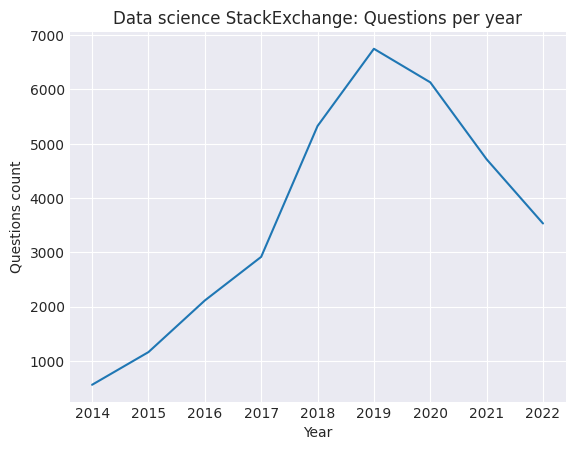

In [33]:
plt.plot(df1_1['year'], df1_1['count'])
plt.xlabel('Year')
plt.ylabel('Questions count')
plt.title('Data science StackExchange: Questions per year')
save_plot('ds_1_questions_per_year')
plt.show()

In [34]:
df1_2 = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') == 2019)\
    .withColumn('month', f.month('creation_date'))\
    .groupBy('month')\
    .count()\
    .orderBy('month')\
    .toPandas()

23/12/20 19:19:57 WARN scheduler.TaskSetManager: Stage 16 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [35]:
df1_2

,month,count
0,1,459
1,2,613
2,3,658
3,4,590
4,5,591
5,6,604
6,7,656
7,8,574
8,9,507
9,10,442


Plot saved to: /home/vagrant/PROJECT/plots/ds_2_questions_2019_per_month.png


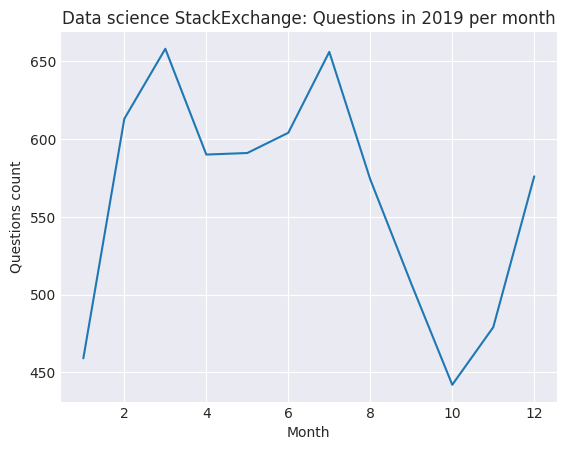

In [36]:
plt.plot(df1_2['month'], df1_2['count'])
plt.xlabel('Month')
plt.ylabel('Questions count')
plt.title('Data science StackExchange: Questions in 2019 per month')
save_plot('ds_2_questions_2019_per_month')
plt.show()

### Analiza dla najbardziej aktywnego roku (2019)

In [37]:
df1_3 = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') == 2019)\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/20 19:20:01 WARN scheduler.TaskSetManager: Stage 21 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:01 WARN scheduler.TaskSetManager: Stage 22 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.


In [38]:
df1_3

,tag,count
0,machine-learning,2130
1,python,1439
2,deep-learning,895
3,neural-network,823
4,keras,705
5,classification,577
6,scikit-learn,448
7,nlp,443
8,tensorflow,409
9,cnn,378


Plot saved to: /home/vagrant/PROJECT/plots/ds_3_tags_2019.png


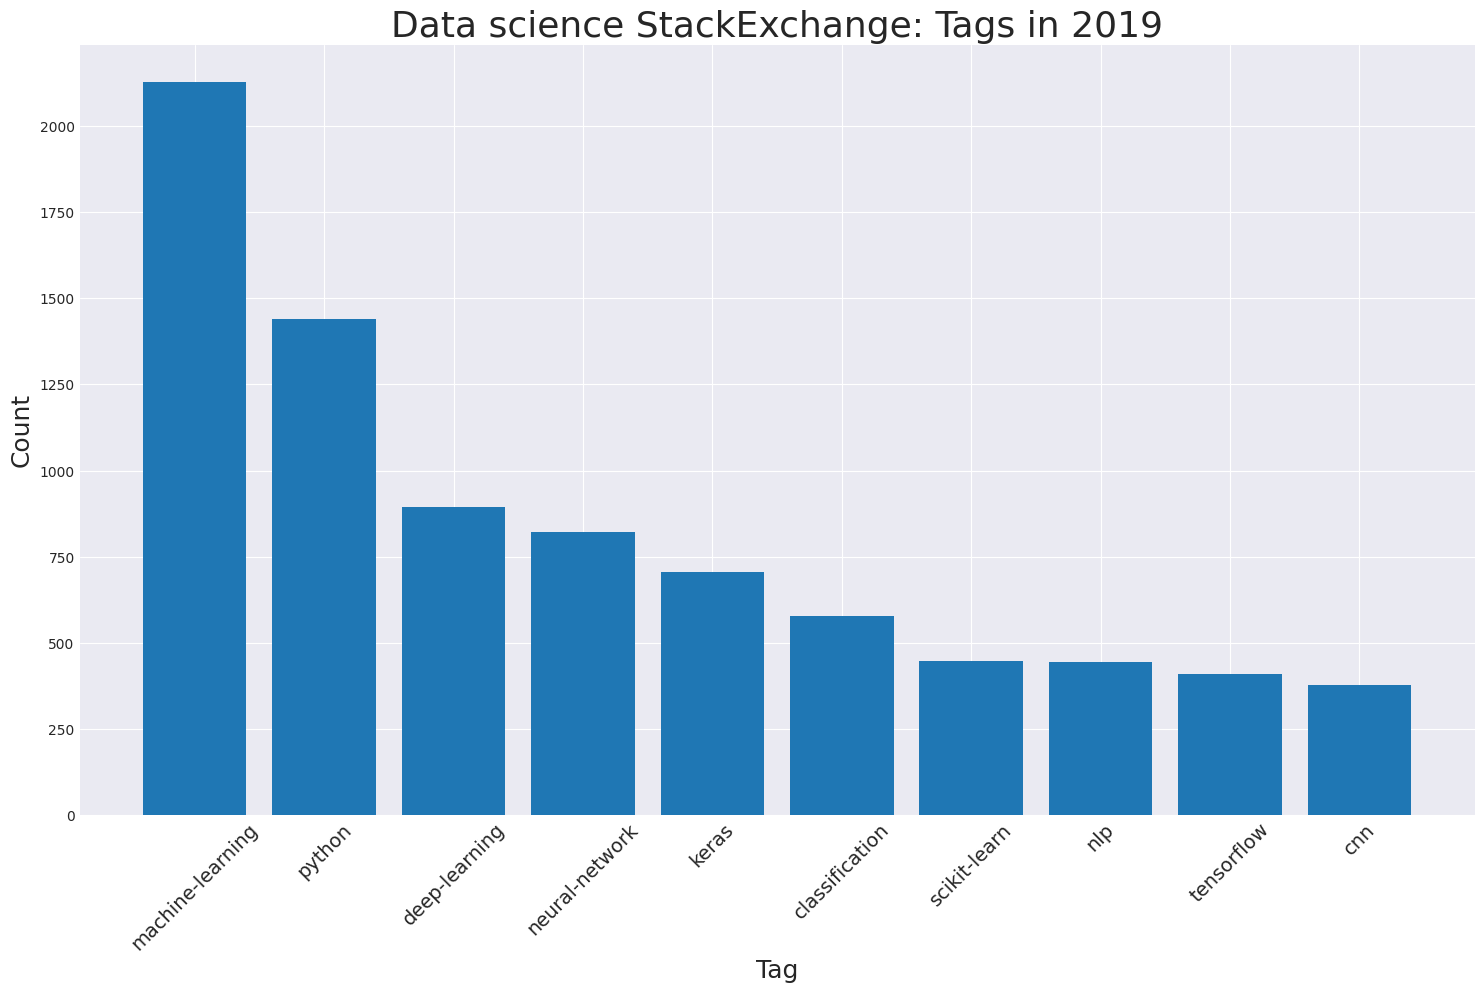

In [39]:
plt.figure(figsize=(18, 10))
plt.bar(df1_3['tag'], df1_3['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Data science StackExchange: Tags in 2019', fontsize=26)
save_plot('ds_3_tags_2019')
plt.show()

### Analiza przed i po 2019

In [40]:
df1_4 = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') < 2019)\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/20 19:20:07 WARN scheduler.TaskSetManager: Stage 25 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:08 WARN scheduler.TaskSetManager: Stage 26 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [41]:
df1_4

,tag,count
0,machine-learning,4085
1,python,2016
2,neural-network,1819
3,deep-learning,1514
4,classification,1173
5,r,824
6,keras,767
7,scikit-learn,745
8,data-mining,696
9,nlp,681


Plot saved to: /home/vagrant/PROJECT/plots/ds_4_tags_2014_to_2018.png


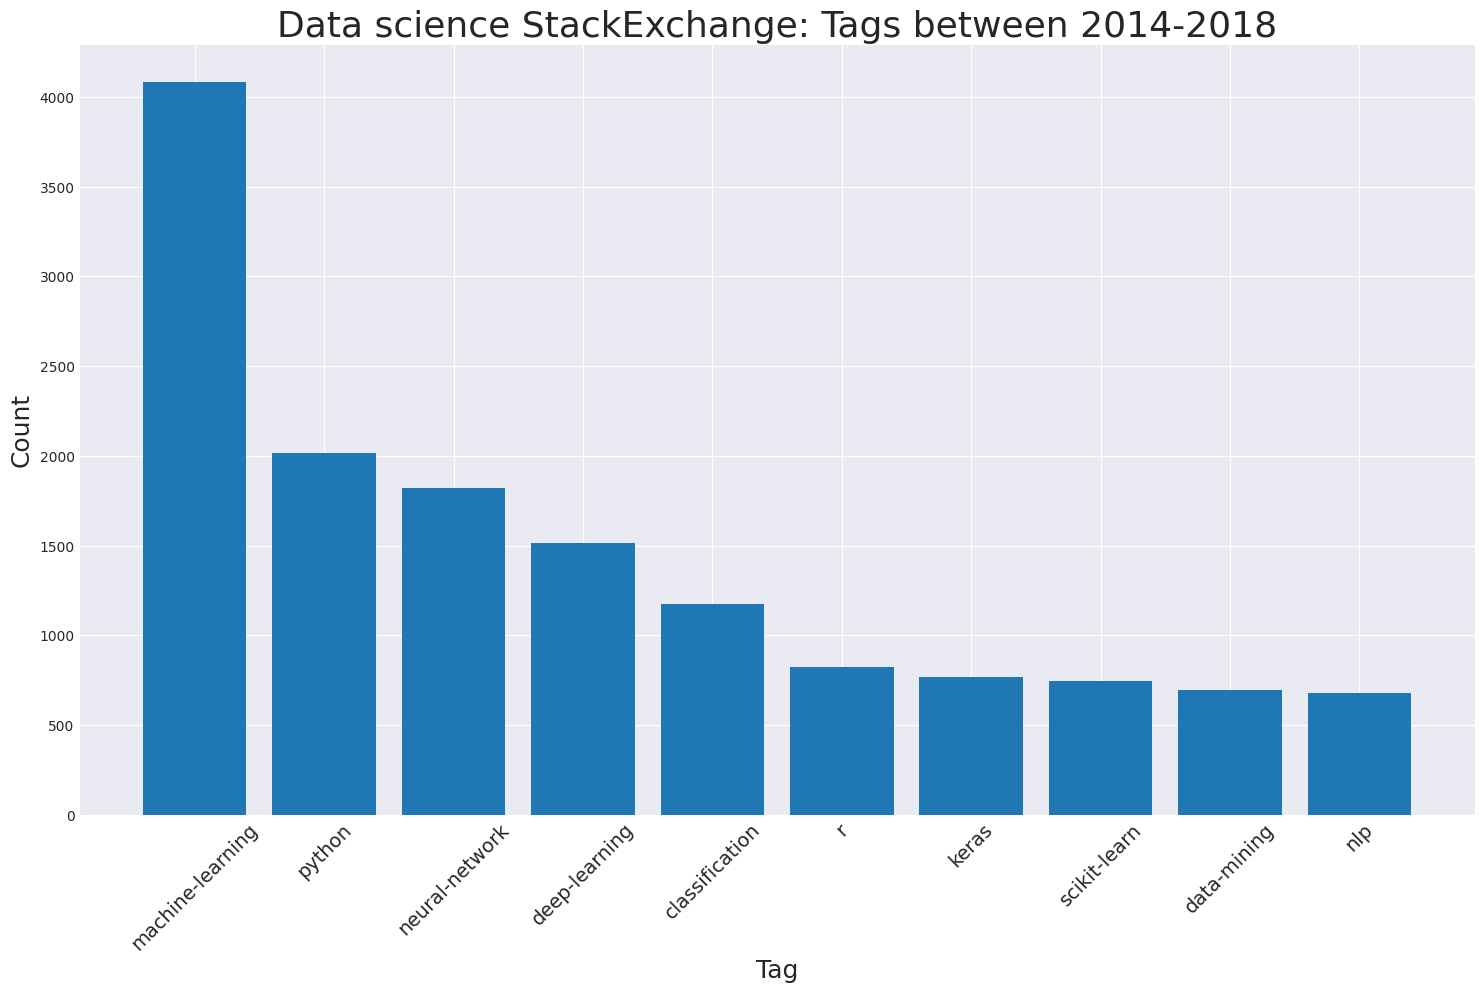

In [42]:
plt.figure(figsize=(18, 10))
plt.bar(df1_4['tag'], df1_4['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Data science StackExchange: Tags between 2014-2018', fontsize=26)
save_plot('ds_4_tags_2014_to_2018')
plt.show()

In [43]:
df1_5 = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') > 2019)\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/20 19:20:13 WARN scheduler.TaskSetManager: Stage 29 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:14 WARN scheduler.TaskSetManager: Stage 30 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [44]:
df1_5

,tag,count
0,machine-learning,5091
1,python,3213
2,deep-learning,2431
3,neural-network,1720
4,nlp,1564
5,classification,1500
6,keras,1269
7,tensorflow,1192
8,scikit-learn,1106
9,time-series,1021


Plot saved to: /home/vagrant/PROJECT/plots/ds_5_tags_2020_to_2023.png


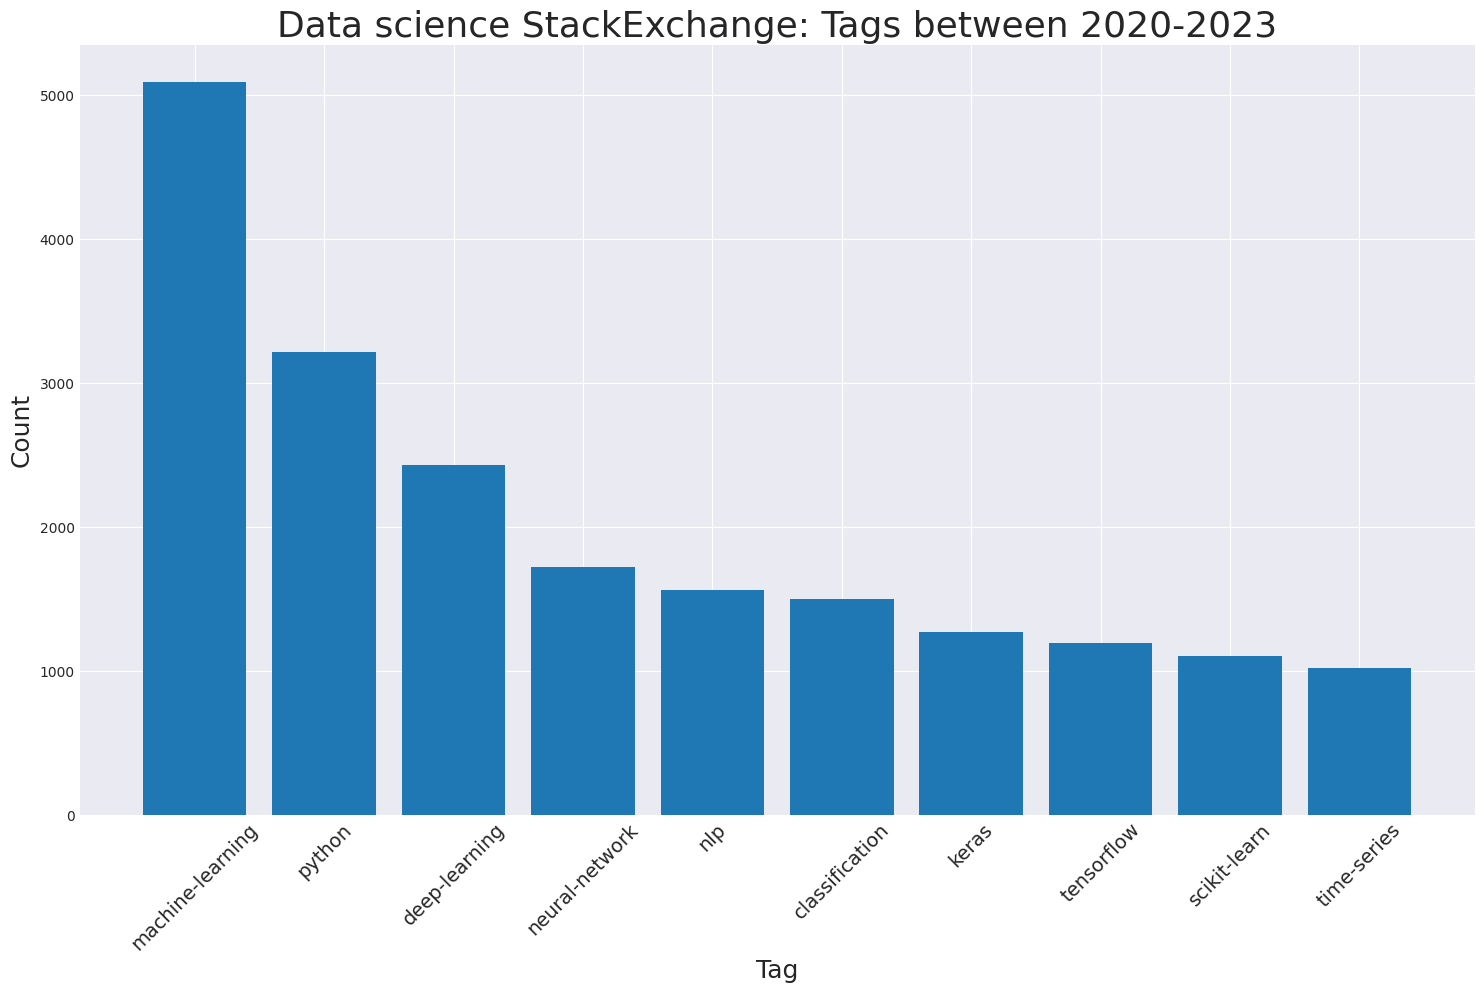

In [45]:
plt.figure(figsize=(18, 10))
plt.bar(df1_5['tag'], df1_5['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Data science StackExchange: Tags between 2020-2023', fontsize=26)
save_plot('ds_5_tags_2020_to_2023')
plt.show()

### Porównanie dwóch kluczowych języków programowania do przetwarzania i analizy danych

In [46]:
df1_6 = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .filter((f.col('tag') == 'r') | (f.col('tag') == 'python'))\
    .groupBy('year', 'tag')\
    .count()\
    .orderBy('year')
df1_6_r = df1_6.filter(f.col('tag') == 'r')\
    .toPandas()
df1_6_py = df1_6.filter(f.col('tag') == 'python')\
    .toPandas()

23/12/20 19:20:20 WARN scheduler.TaskSetManager: Stage 33 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:21 WARN scheduler.TaskSetManager: Stage 34 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:26 WARN scheduler.TaskSetManager: Stage 42 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:26 WARN scheduler.TaskSetManager: Stage 43 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.


In [47]:
df1_6_r

,year,tag,count
0,2014,r,54
1,2015,r,153
2,2016,r,210
3,2017,r,204
4,2018,r,203
5,2019,r,194
6,2020,r,191
7,2021,r,128
8,2022,r,83


In [48]:
df1_6_py

,year,tag,count
0,2014,python,43
1,2015,python,130
2,2016,python,313
3,2017,python,473
4,2018,python,1057
5,2019,python,1439
6,2020,python,1203
7,2021,python,900
8,2022,python,609


Plot saved to: /home/vagrant/PROJECT/plots/ds_6_python_vs_r.png


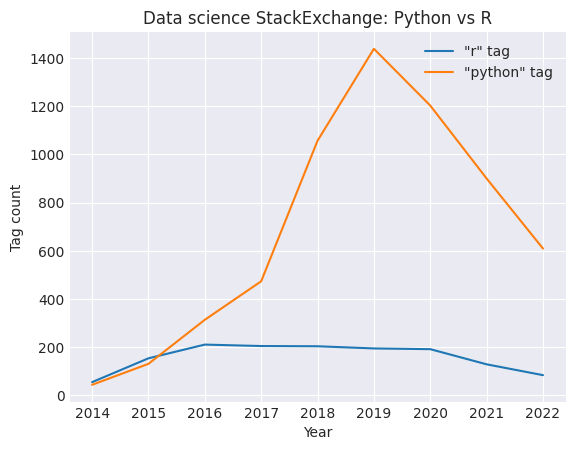

In [49]:
plt.plot(df1_6_r['year'], df1_6_r['count'], label='"r" tag')
plt.plot(df1_6_py['year'], df1_6_py['count'], label='"python" tag')
plt.xlabel('Year')
plt.ylabel('Tag count')
plt.title('Data science StackExchange: Python vs R')
plt.legend()
save_plot('ds_6_python_vs_r')
plt.show()

### Liczba zakładanych kont na przestrzeni lat

In [50]:
df1_7 = df_datascience_users\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .count()\
    .orderBy('year')\
    .toPandas()

23/12/20 19:20:31 WARN scheduler.TaskSetManager: Stage 51 contains a task of very large size (2942 KiB). The maximum recommended task size is 1000 KiB.


In [51]:
df1_7

,year,count
0,2014,3406
1,2015,6141
2,2016,9827
3,2017,14187
4,2018,18928
5,2019,20245
6,2020,19850
7,2021,16606
8,2022,13803


Plot saved to: /home/vagrant/PROJECT/plots/ds_7_accounts_per_year.png


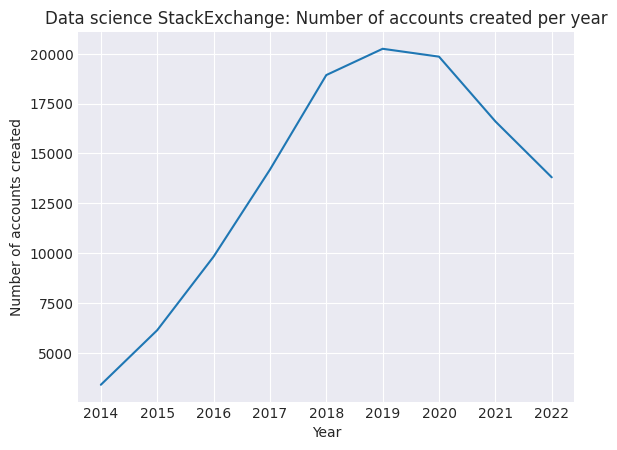

In [52]:
plt.plot(df1_7['year'], df1_7['count'])
plt.xlabel('Year')
plt.ylabel('Number of accounts created')
plt.title('Data science StackExchange: Number of accounts created per year')
save_plot('ds_7_accounts_per_year')
plt.show()

### Porównianie średniego score pytań na rok

In [53]:
df1_8 = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .avg('score')\
    .orderBy('year')\
    .toPandas()

23/12/20 19:20:34 WARN scheduler.TaskSetManager: Stage 56 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [54]:
df1_8

,year,avg(score)
0,2014,11.345259
1,2015,5.162791
2,2016,4.799716
3,2017,3.356996
4,2018,2.697522
5,2019,1.849015
6,2020,1.450008
7,2021,0.948228
8,2022,0.676296


Plot saved to: /home/vagrant/PROJECT/plots/ds_8_avg_question_score_per_year.png


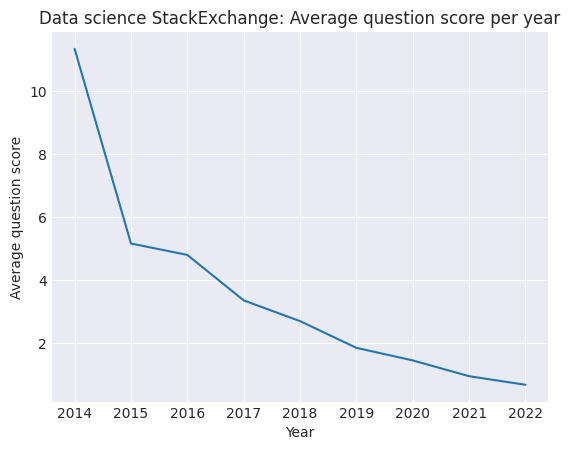

In [55]:
plt.plot(df1_8['year'], df1_8['avg(score)'])
plt.xlabel('Year')
plt.ylabel('Average question score')
plt.title('Data science StackExchange: Average question score per year')
save_plot('ds_8_avg_question_score_per_year')
plt.show()

### Różnica między wzrostami/spadkami liczby wyświetleń oraz odpowiedzi do postów

In [56]:
df1_9_answers = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .sum('answer_count')\
    .orderBy('year')\
    .toPandas()
df1_9_views = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .sum('view_count')\
    .orderBy('year')\
    .toPandas()

23/12/20 19:20:36 WARN scheduler.TaskSetManager: Stage 61 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:38 WARN scheduler.TaskSetManager: Stage 66 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [57]:
df1_9_answers

,year,sum(answer_count)
0,2014,1367
1,2015,2030
2,2016,3367
3,2017,3911
4,2018,6951
5,2019,8038
6,2020,6525
7,2021,4123
8,2022,2969


Plot saved to: /home/vagrant/PROJECT/plots/ds_9a_answers_per_year.png


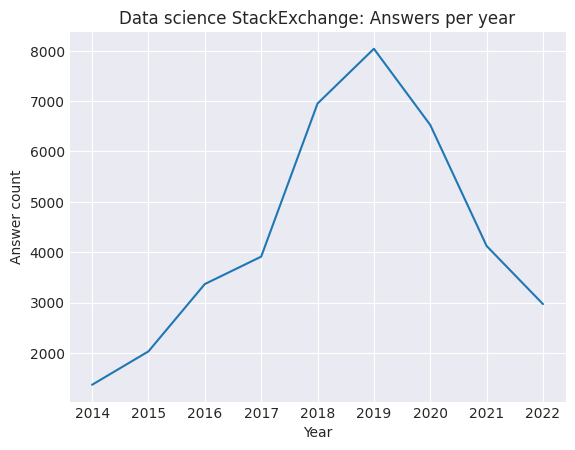

In [58]:
plt.plot(df1_9_answers['year'], df1_9_answers['sum(answer_count)'])
plt.xlabel('Year')
plt.ylabel('Answer count')
plt.title('Data science StackExchange: Answers per year')
save_plot('ds_9a_answers_per_year')
plt.show()

In [59]:
df1_9_views

,year,sum(view_count)
0,2014,3816144
1,2015,5607976
2,2016,12636715
3,2017,12478154
4,2018,18286546
5,2019,12538422
6,2020,6114577
7,2021,2578499
8,2022,1160567


Plot saved to: /home/vagrant/PROJECT/plots/ds_9b_views_per_year.png


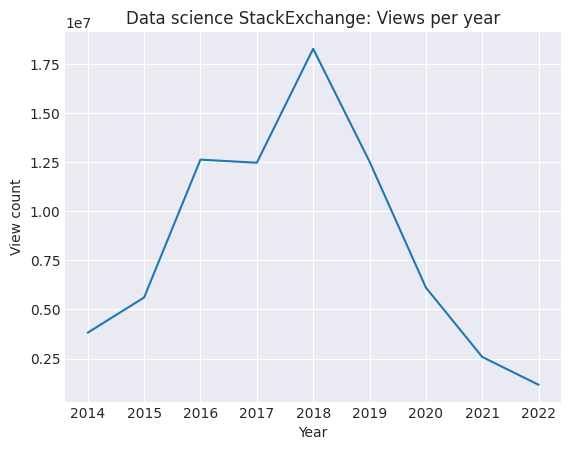

In [60]:
plt.plot(df1_9_views['year'], df1_9_views['sum(view_count)'])
plt.xlabel('Year')
plt.ylabel('View count')
plt.title('Data science StackExchange: Views per year')
save_plot('ds_9b_views_per_year')
plt.show()

# Stack Overflow

## Most popular tags (by post count)

In [61]:
df2_1_pc = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/20 19:20:42 WARN scheduler.TaskSetManager: Stage 71 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:42 WARN scheduler.TaskSetManager: Stage 72 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.


In [62]:
df2_1_pc

,tag,count
0,python,13216
1,javascript,8975
2,reactjs,4891
3,java,4254
4,c#,3791
5,html,3382
6,android,2951
7,r,2668
8,flutter,2525
9,node.js,2512


Plot saved to: /home/vagrant/PROJECT/plots/stack_1a_tags_post_count.png


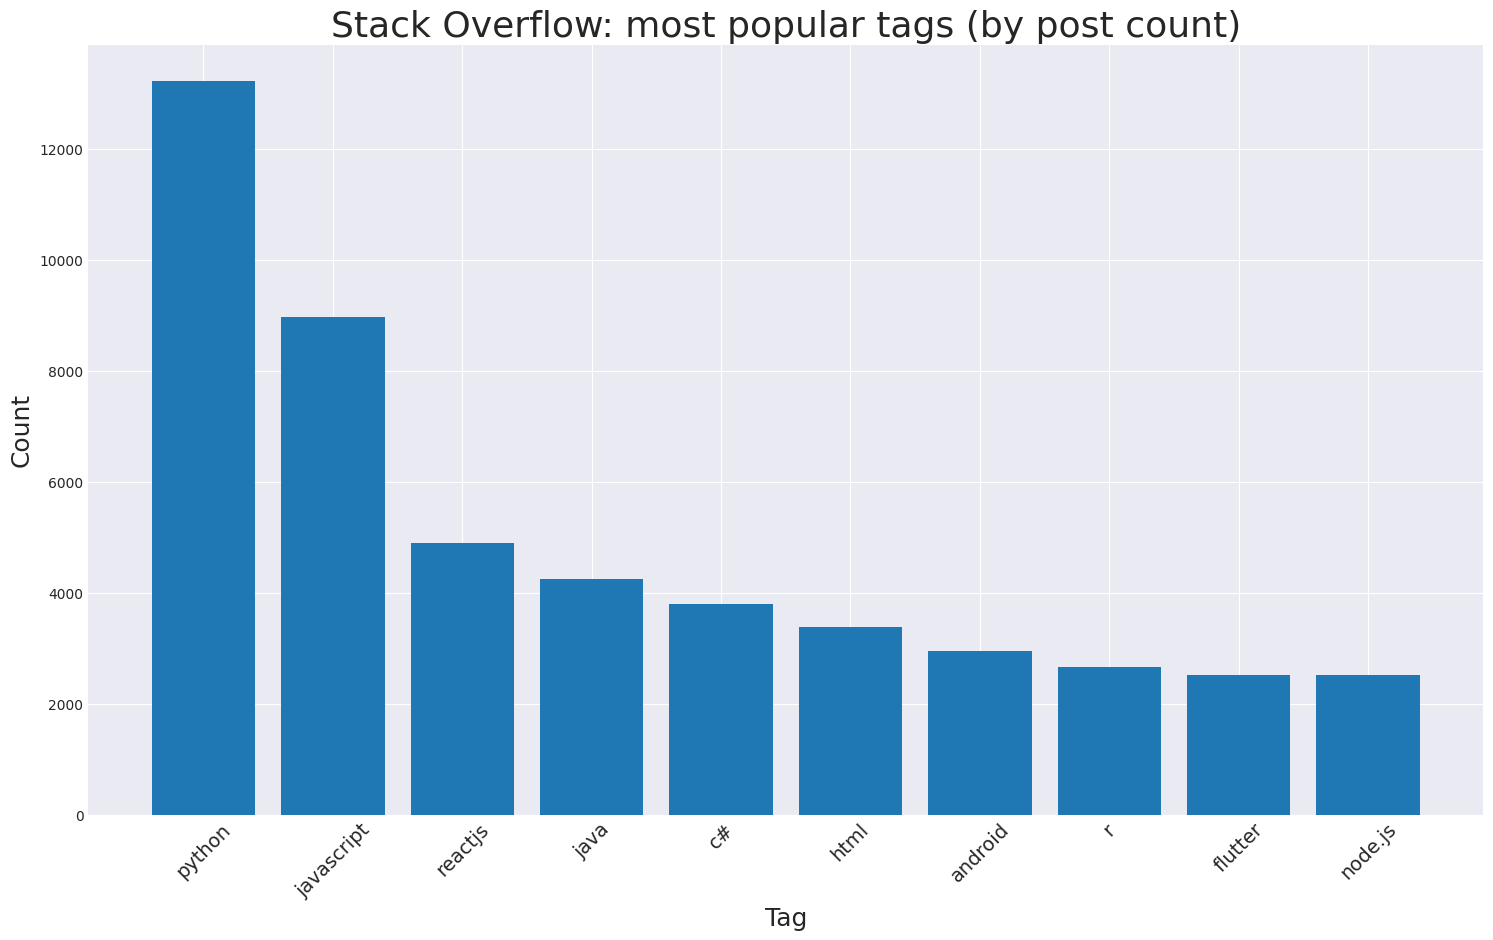

In [63]:
plt.figure(figsize=(18, 10))
plt.bar(df2_1_pc['tag'], df2_1_pc['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Stack Overflow: most popular tags (by post count)', fontsize=26)
save_plot('stack_1a_tags_post_count')
plt.show()

## Most popular tags (by view count)

In [64]:
df2_1_vc = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .groupBy('tag')\
    .agg(f.sum('post_view_count').alias('total_view_count'))\
    .orderBy('total_view_count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/20 19:20:51 WARN scheduler.TaskSetManager: Stage 75 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:51 WARN scheduler.TaskSetManager: Stage 76 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.


In [65]:
df2_1_vc

,tag,total_view_count
0,python,4643329
1,javascript,3956478
2,reactjs,3175728
3,java,1797450
4,android,1593532
5,flutter,1404858
6,node.js,1329396
7,c#,1321437
8,typescript,1076524
9,next.js,1015874


Plot saved to: /home/vagrant/PROJECT/plots/stack_1b_tags_view_count.png


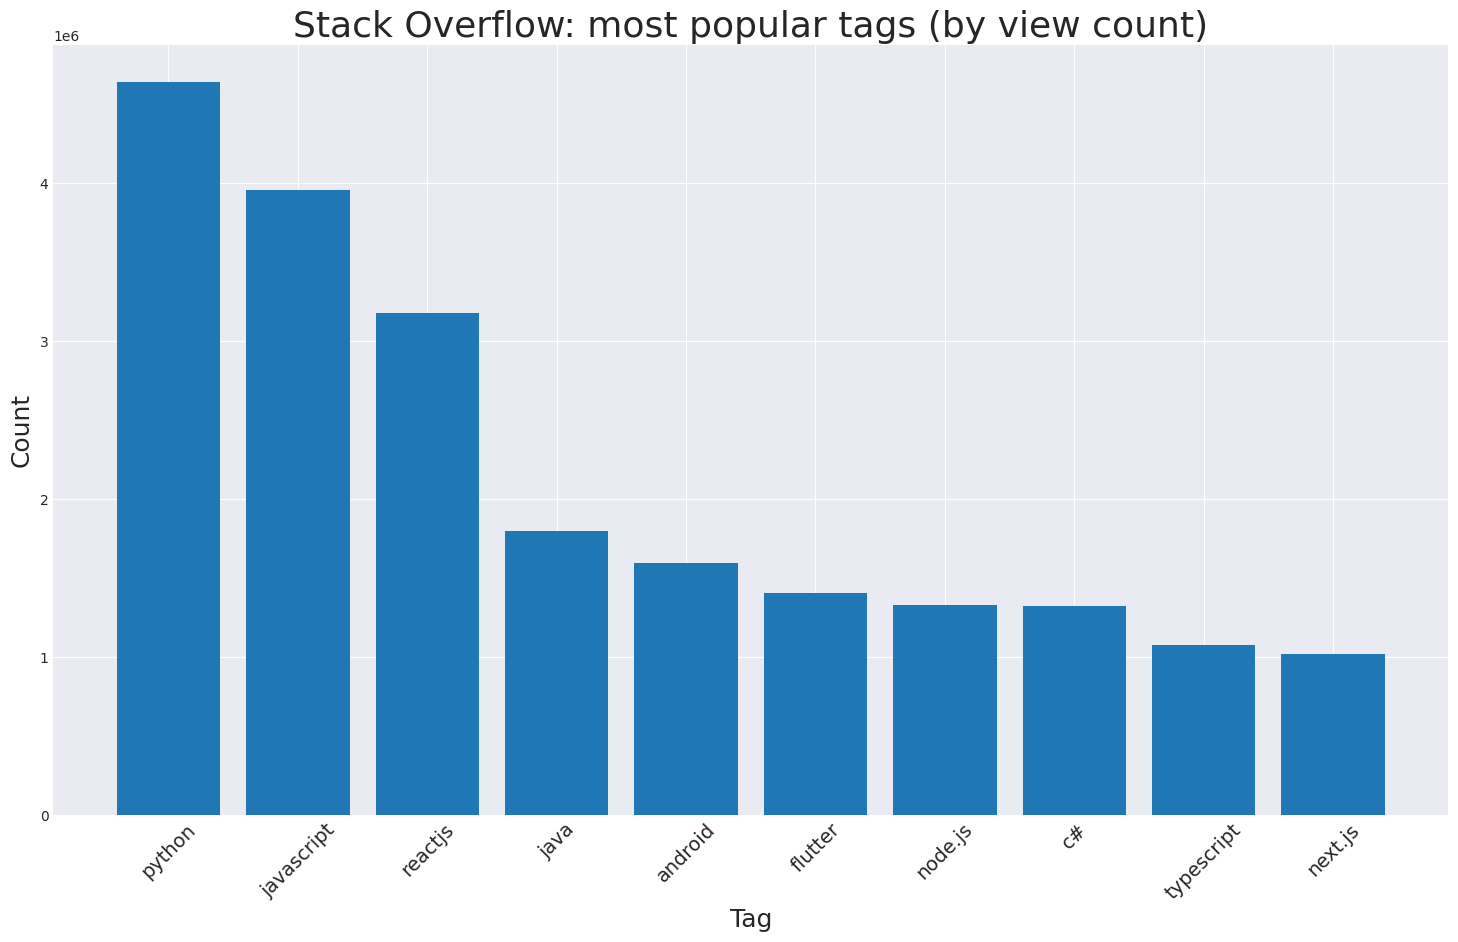

In [66]:
plt.figure(figsize=(18, 10))
plt.bar(df2_1_vc['tag'], df2_1_vc['total_view_count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Stack Overflow: most popular tags (by view count)', fontsize=26)
save_plot('stack_1b_tags_view_count')
plt.show()

## Most viewed posts

In [67]:
np.bool = bool

In [68]:
df2_2 = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .groupBy('question_id', 'post_view_count', 'post_title')\
    .agg(f.concat_ws(", ", f.collect_list(f.col('tag'))).alias("tags"))\
    .orderBy('post_view_count', ascending=False)\
    .toPandas()

23/12/20 19:20:58 WARN scheduler.TaskSetManager: Stage 79 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:20:59 WARN scheduler.TaskSetManager: Stage 80 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.


In [69]:
df2_2

,question_id,post_view_count,post_title,tags
0,76541695,228969,Ionic - how to prevent error &quot;TS2339: Pro...,"angular, ionic-framework"
1,71702392,175222,ViewPropTypes will be removed from React Nativ...,react-native
2,71901632,170102,Fatal error &quot;unsafe repository (&#39;/hom...,"git, cve-2022-24765"
3,71944111,122929,Redux createStore() is deprecated - Cannot get...,"javascript, redux, redux-toolkit"
4,71201741,87148,How to use Font Awesome 6 icons?,"font-awesome, font-awesome-6"
...,...,...,...,...
85345,77182405,4,trying to install spyder into working environm...,"spyder, anaconda3"
85346,77575791,4,How to keep the windows casting ( WinKey + K) ...,"casting, screen, display, sharing, split-screen"
85347,76336502,3,Intersect method does not appear to work with ...,"forms, methods, intersect"
85348,74854240,3,using onclck to pass button id and using switc...,"function, switch-statement, case"


In [70]:
df2_2[0:10]

,question_id,post_view_count,post_title,tags
0,76541695,228969,Ionic - how to prevent error &quot;TS2339: Pro...,"angular, ionic-framework"
1,71702392,175222,ViewPropTypes will be removed from React Nativ...,react-native
2,71901632,170102,Fatal error &quot;unsafe repository (&#39;/hom...,"git, cve-2022-24765"
3,71944111,122929,Redux createStore() is deprecated - Cannot get...,"javascript, redux, redux-toolkit"
4,71201741,87148,How to use Font Awesome 6 icons?,"font-awesome, font-awesome-6"
5,70625340,86760,Uncaught (in promise) TypeError: Cannot read p...,"javascript, reactjs, validation"
6,72242713,82312,Kubectl error upon applying agones fleet: ensu...,"kubernetes, minikube, agones"
7,72509865,78524,Error: There was an error while hydrating. Bec...,"javascript, reactjs, next.js, tailwind-css"
8,73795935,75992,Sign_and_send_pubkey: no mutual signature supp...,"ssh, openssh"
9,76616042,70751,AttributeError: module &#39;PIL.Image&#39; has...,"python, python-imaging-library"


In [71]:
next(df2_2[0:10].iterrows())

(0,
 question_id                                                 76541695
 post_view_count                                               228969
 post_title         Ionic - how to prevent error &quot;TS2339: Pro...
 tags                                        angular, ionic-framework
 Name: 0, dtype: object)

In [72]:
for rank, data in df2_2[0:10].iterrows():
    print(f'No. ' + f'{rank+1}:'.ljust(4) + f'{data["post_title"]}\n'
          f'\tviews: {data["post_view_count"]}   |   tags: {data["tags"]}')
    print("===================================================================================================================")
# https://stackoverflow.com/questions/76541695/ionic-how-to-prevent-error-ts2339-property-xxx-does-not-exist-on-type

No. 1:  Ionic - how to prevent error &quot;TS2339: Property XXX does not exist on type&quot;
	views: 228969   |   tags: angular, ionic-framework
No. 2:  ViewPropTypes will be removed from React Native. Migrate to ViewPropTypes exported from &#39;deprecated-react-native-prop-types
	views: 175222   |   tags: react-native
No. 3:  Fatal error &quot;unsafe repository (&#39;/home/repon&#39; is owned by someone else)&quot;
	views: 170102   |   tags: git, cve-2022-24765
No. 4:  Redux createStore() is deprecated - Cannot get state from getState() in Redux action
	views: 122929   |   tags: javascript, redux, redux-toolkit
No. 5:  How to use Font Awesome 6 icons?
	views: 87148   |   tags: font-awesome, font-awesome-6
No. 6:  Uncaught (in promise) TypeError: Cannot read properties of undefined (reading &#39;data&#39;)
	views: 86760   |   tags: javascript, reactjs, validation
No. 7:  Kubectl error upon applying agones fleet: ensure CRDs are installed first
	views: 82312   |   tags: kubernetes, mini

## Tags appearing with `python` tag

In [73]:
posts_with_python = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .filter(f.col('tag') == 'python')\
    .withColumnRenamed('tag', 'python_tag')\
    .select('question_id', 'python_tag')

In [74]:
df2_3 = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .join(posts_with_python, on='question_id', how='left')\
    .filter((f.col('python_tag') == 'python') & (f.col('tag') != 'python'))\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/20 19:21:12 WARN scheduler.TaskSetManager: Stage 86 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:13 WARN scheduler.TaskSetManager: Stage 87 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:13 WARN scheduler.TaskSetManager: Stage 88 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.


In [75]:
df2_3

,tag,count
0,pandas,1819
1,python-3.x,988
2,dataframe,836
3,django,649
4,numpy,540
5,list,381
6,matplotlib,345
7,tensorflow,289
8,tkinter,261
9,flask,251


Plot saved to: /home/vagrant/PROJECT/plots/stack_3_tags_with_python.png


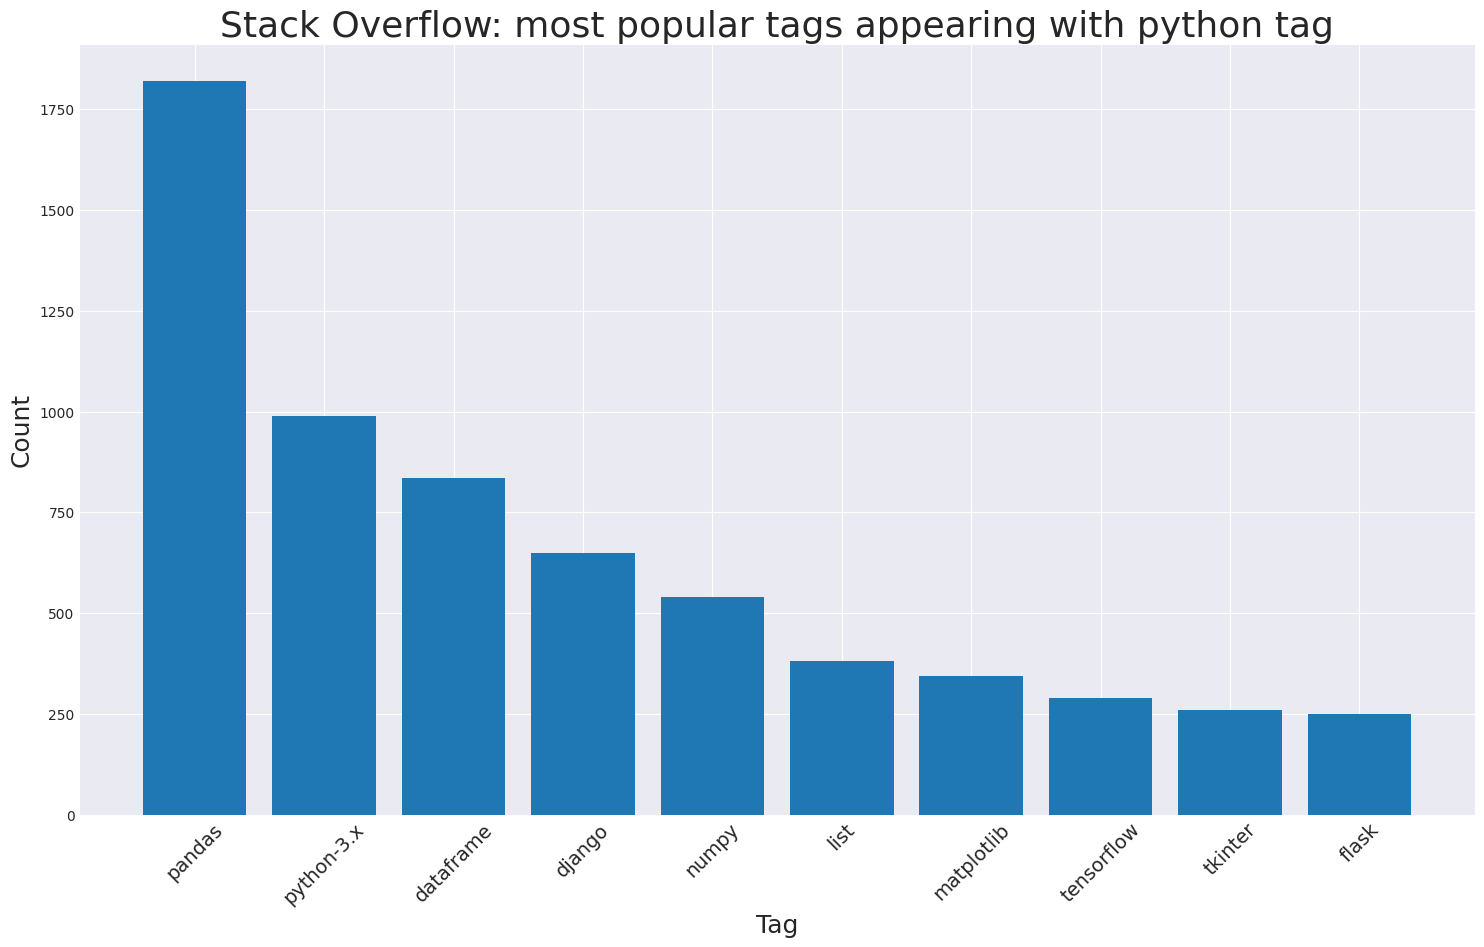

In [76]:
plt.figure(figsize=(18, 10))
plt.bar(df2_3['tag'], df2_3['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Stack Overflow: most popular tags appearing with python tag', fontsize=26)
save_plot('stack_3_tags_with_python')
plt.show()

## Tags appearing with `R` tag

In [77]:
posts_with_r = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .filter(f.col('tag') == 'r')\
    .withColumnRenamed('tag', 'r_tag')\
    .select('question_id', 'r_tag')

In [78]:
df2_4 = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .join(posts_with_r, on='question_id', how='left')\
    .filter((f.col('r_tag') == 'r') & (f.col('tag') != 'r'))\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/20 19:21:19 WARN scheduler.TaskSetManager: Stage 91 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:20 WARN scheduler.TaskSetManager: Stage 92 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:20 WARN scheduler.TaskSetManager: Stage 93 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.


Plot saved to: /home/vagrant/PROJECT/plots/stack_4_tags_with_r.png


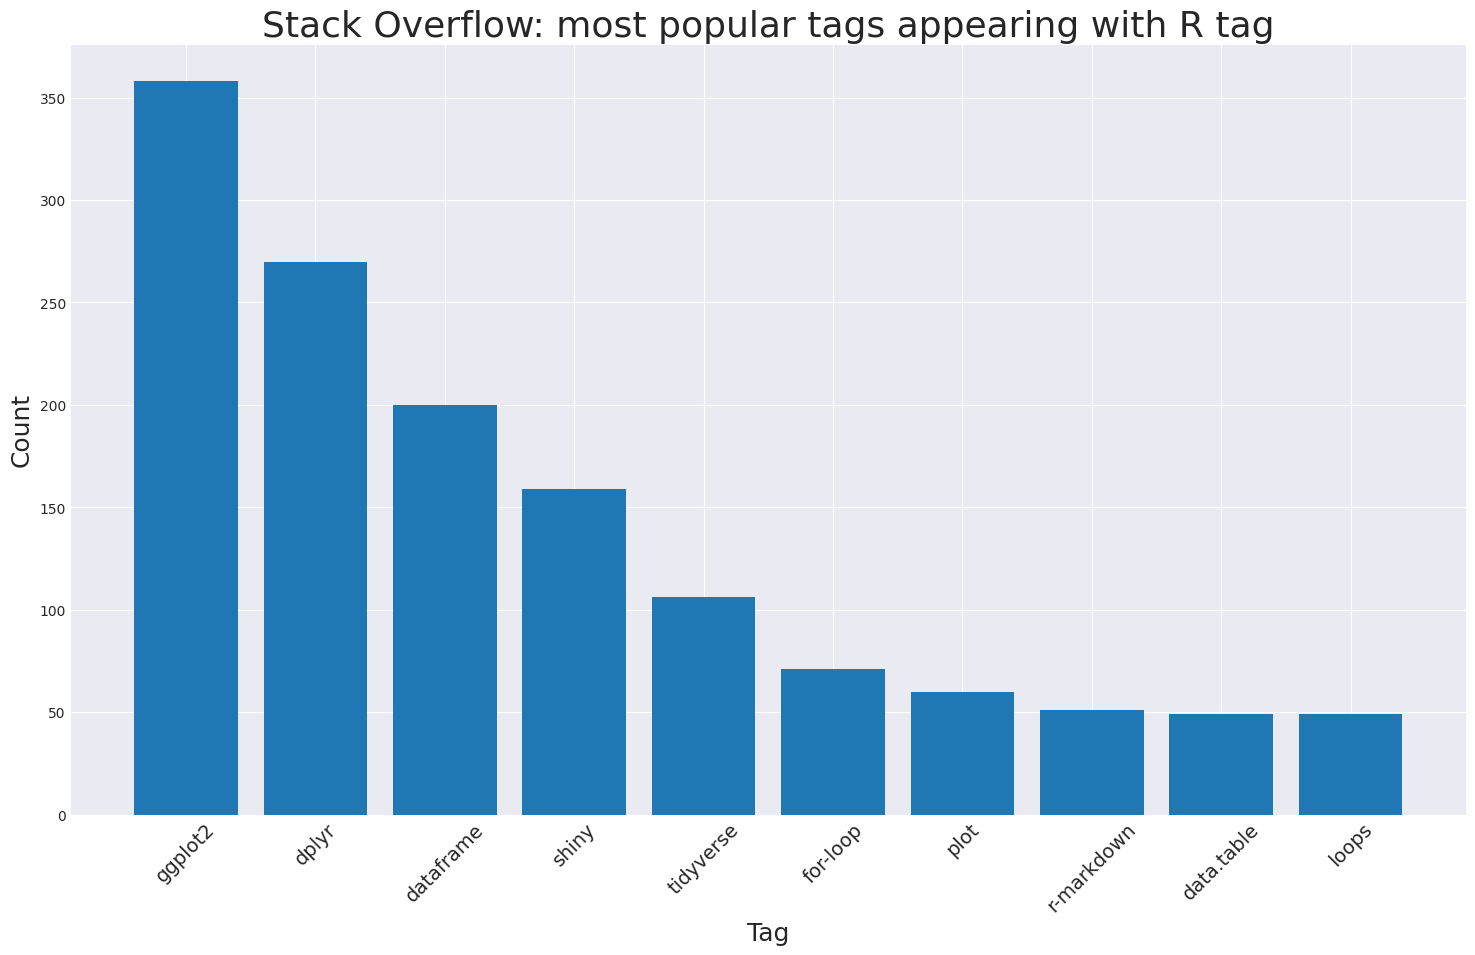

In [79]:
plt.figure(figsize=(18, 10))
plt.bar(df2_4['tag'], df2_4['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Stack Overflow: most popular tags appearing with R tag', fontsize=26)
save_plot('stack_4_tags_with_r')
plt.show()

## Python vs R comparison in 2023 across Data Science Stack Exchange and Stack Overflow

In [80]:
# added columns explained:
# - month, year - creation month / year
# - month_year - month and year concatenated in a human readable way, 
#                e.g. October 2023 is 10/2023
# - month_year_numeric - month and year concatenated in a way that enables easy filtering by date range, 
#                        e.g. October 2023 is 202310 (year * 100 + month)
df2_5_ds = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .withColumn('month', f.month('creation_date'))\
    .withColumn('month_year', f.concat_ws('/', f.col('month'), f.col('year')))\
    .withColumn('month_year_numeric', f.col('year') * 100 + f.col('month'))\
    .filter((f.col('month_year_numeric') >= 202201) & (f.col('month_year_numeric') <= 202311))\
    .filter((f.col('tag') == 'r') | (f.col('tag') == 'python'))\
    .groupBy('month_year', 'month_year_numeric', 'tag')\
    .count()\
    .groupBy('month_year', 'month_year_numeric')\
    .pivot('tag')\
    .sum('count')\
    .orderBy('month_year_numeric')\
    .withColumn('ratio', f.col('python')/f.col('r'))\
    .toPandas()

23/12/20 19:21:25 WARN scheduler.TaskSetManager: Stage 96 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:25 WARN scheduler.TaskSetManager: Stage 97 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:29 WARN scheduler.TaskSetManager: Stage 102 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:29 WARN scheduler.TaskSetManager: Stage 103 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.


In [81]:
df2_5_ds

,month_year,month_year_numeric,python,r,ratio
0,1/2022,202201,61,6,10.166667
1,2/2022,202202,40,13,3.076923
2,3/2022,202203,50,11,4.545455
3,4/2022,202204,45,9,5.000000
4,5/2022,202205,60,6,10.000000
5,6/2022,202206,47,4,11.750000
6,7/2022,202207,42,2,21.000000
7,8/2022,202208,44,6,7.333333
8,9/2022,202209,55,5,11.000000
9,10/2022,202210,57,7,8.142857


In [82]:
df2_5_stack = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .withColumn('year', f.year('post_creation_date'))\
    .withColumn('month', f.month('post_creation_date'))\
    .withColumn('month_year', f.concat_ws('/', f.col('month'), f.col('year')))\
    .withColumn('month_year_numeric', f.col('year') * 100 + f.col('month'))\
    .filter((f.col('month_year_numeric') >= 202201) & (f.col('month_year_numeric') <= 202311))\
    .filter((f.col('tag') == 'r') | (f.col('tag') == 'python'))\
    .groupBy('month_year', 'month_year_numeric', 'tag')\
    .count()\
    .groupBy('month_year', 'month_year_numeric')\
    .pivot('tag')\
    .sum('count')\
    .orderBy('month_year_numeric')\
    .withColumn('ratio', f.col('python')/f.col('r'))\
    .toPandas()

23/12/20 19:21:35 WARN scheduler.TaskSetManager: Stage 113 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:35 WARN scheduler.TaskSetManager: Stage 114 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:40 WARN scheduler.TaskSetManager: Stage 119 contains a task of very large size (5526 KiB). The maximum recommended task size is 1000 KiB.
23/12/20 19:21:41 WARN scheduler.TaskSetManager: Stage 120 contains a task of very large size (2358 KiB). The maximum recommended task size is 1000 KiB.


In [83]:
df2_5_stack

,month_year,month_year_numeric,python,r,ratio
0,1/2022,202201,625,114,5.482456
1,2/2022,202202,558,116,4.810345
2,3/2022,202203,646,122,5.295082
3,4/2022,202204,617,116,5.318966
4,5/2022,202205,616,123,5.008130
5,6/2022,202206,632,114,5.543860
6,7/2022,202207,637,119,5.352941
7,8/2022,202208,627,134,4.679104
8,9/2022,202209,637,110,5.790909
9,10/2022,202210,669,118,5.669492


Analysis is performed only on data between January 2022 and November 2023 because it is the only period where data from both sources overlaps

Plot saved to: /home/vagrant/PROJECT/plots/stack_ds_5_python_r_ratio.png


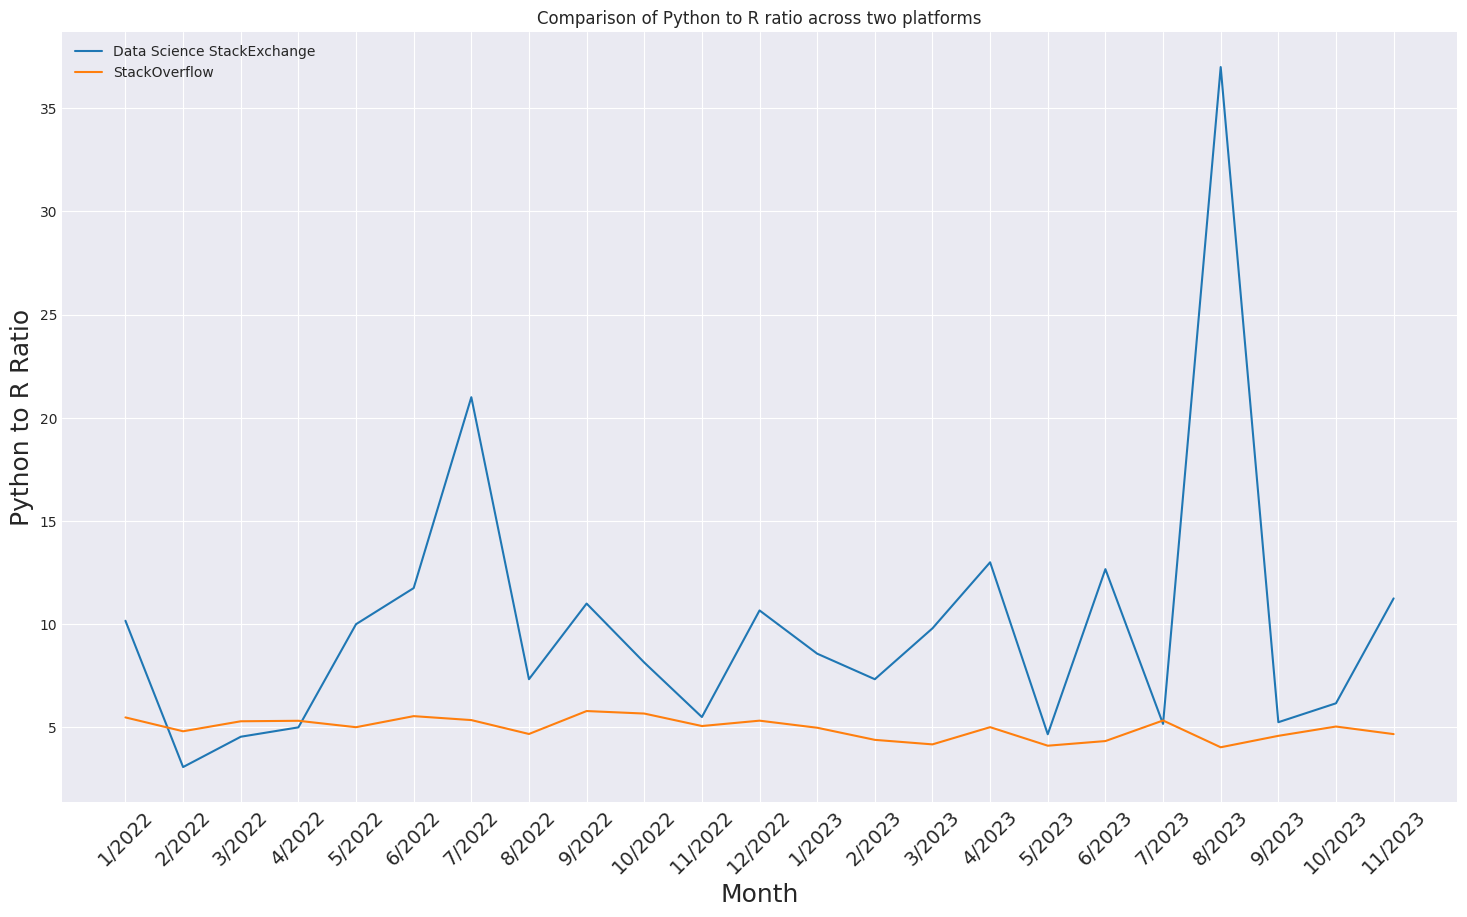

In [85]:
plt.figure(figsize=(18, 10))
plt.plot(df2_5_ds['month_year'], df2_5_ds['ratio'], label='Data Science StackExchange')
plt.plot(df2_5_stack['month_year'], df2_5_stack['ratio'], label='StackOverflow')
plt.xlabel('Month', fontsize=18)
plt.ylabel('Python to R Ratio', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Comparison of Python to R ratio across two platforms')
plt.legend()
save_plot('stack_ds_5_python_r_ratio')
plt.show()